# Stress Testing Common XAI Algos in the Literature

In [ ]:
%pip install ipython --upgrade

In [17]:
import pandas as pd
import numpy as np
import lime
import os
import sys
from datetime import datetime

from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
from pyAgrum.skbn import BNClassifier

from pyAgrum.lib.bn2roc import showROC, showPR, showROC_PR

SMALL_SIZE = 10
MEDIUM_SIZE = 12

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rcParams['figure.dpi']=150

sns.set()

## Case #1: Data Generated from a Common Cause Structure with Independent Vars

The purpose of this test is to understand how current algorithms of the literature such as LIME and SHAP can represent feature in important in situations where data is generated from a common cause structure. We also added an independent variable to understand if this variable will be considered as relevant to the algorithm. We will train an XGboost classifier with data generated from the model below and run XAI algortihms to understand the computed feature importance.

<img src="https://raw.githubusercontent.com/catarina-moreira/XAI_Algos/0de91f13187c7a136676e049804c6b6e4de3ff44/networks/common_cause.png" />

In [2]:
# load the common cause data
data_common_cause = pd.read_csv(os.path.join("gen_data", "common_cause_v2.dat"))
data_common_cause.head()

,X1,X2,X3,Y
0,0.162166,0,0.341992,0
1,0.724821,1,0.666446,0
2,0.784591,1,0.956853,1
3,0.216756,0,0.625276,0
4,0.828123,0,0.300219,1


In [56]:
np.argmax(Y.values)

0

In [60]:
rtest = map(np.argmax, Y.values)
list(rtest)

[0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,


In [3]:
class_var = "Y"
features = data_common_cause.columns.to_list()
features.remove(class_var)

X = data_common_cause[features]
y = data_common_cause[class_var]

Y = pd.DataFrame([], columns=["Y_0", "Y_1"])
for indx in range(len(y.values)):
  if y.values[indx] == 0:
    Y.loc[indx, :] = [1,0]
  else:
    Y.loc[indx, :] = [0,1]

Y = Y.astype('float32')

In [63]:
to_categorical(y)

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [49]:
# for NN
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.3, random_state=515)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=515)

In [47]:
# train a BN Classifer
clf = BNClassifier(learningMethod='MIIC', prior='Smoothing', priorWeight=1, discretizationNbBins=4, discretizationStrategy="kmeans",usePR=False)
clf.fit(X_train,y_train)
accuracy_bn = clf.score(X_test, y_test)
accuracy_bn

0.992

In [48]:
bayesNet = clf.bn
bayesNet

(pyAgrum.BayesNet<double>@0x7fe0b0082e00) BN{nodes: 4, arcs: 3, domainSize: 64, dim: 30}

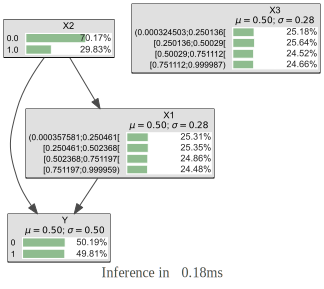

In [42]:
gnb.showInference(bayesNet)

In [4]:
# for NN
X_train, X_test, y_train, y_test = train_test_split(X.values, Y.values, test_size=0.3, random_state=515)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=515)

### Training a Neural Network Classifier


In [50]:
act_fn = "tanh"
nn = tf.keras.Sequential([
  layers.Dense(7, activation=act_fn, input_shape=(X_train.shape[-1],) ),
  layers.Dense(5, activation=act_fn),
  layers.Dense(3, activation=act_fn),
  layers.Dense(1, activation="softmax")
])

learning_rate = 0.001
nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
           loss="binary_crossentropy",
            metrics=["accuracy"])

batch_size = 32
history = nn.fit(X_train, y_train, 
          epochs=50, 
          batch_size=batch_size, 
          validation_data=(X_val, y_val),
          verbose=1)

Epoch 1/50
110/110 [==============================] - 1s 2ms/step - loss: 0.6308 - accuracy: 0.4951 - val_loss: 0.5687 - val_accuracy: 0.4947
Epoch 2/50
110/110 [==============================] - 0s 1ms/step - loss: 0.4938 - accuracy: 0.4951 - val_loss: 0.4426 - val_accuracy: 0.4947
Epoch 3/50
110/110 [==============================] - 0s 1ms/step - loss: 0.3755 - accuracy: 0.4951 - val_loss: 0.3444 - val_accuracy: 0.4947
Epoch 4/50
110/110 [==============================] - 0s 1ms/step - loss: 0.2879 - accuracy: 0.4951 - val_loss: 0.2651 - val_accuracy: 0.4947
Epoch 5/50
110/110 [==============================] - 0s 1ms/step - loss: 0.2217 - accuracy: 0.4951 - val_loss: 0.2052 - val_accuracy: 0.4947
Epoch 6/50
110/110 [==============================] - 0s 1ms/step - loss: 0.1747 - accuracy: 0.4951 - val_loss: 0.1663 - val_accuracy: 0.4947
Epoch 7/50
110/110 [==============================] - 0s 1ms/step - loss: 0.1417 - accuracy: 0.4951 - val_loss: 0.1333 - val_accuracy: 0.4947
Epoch 

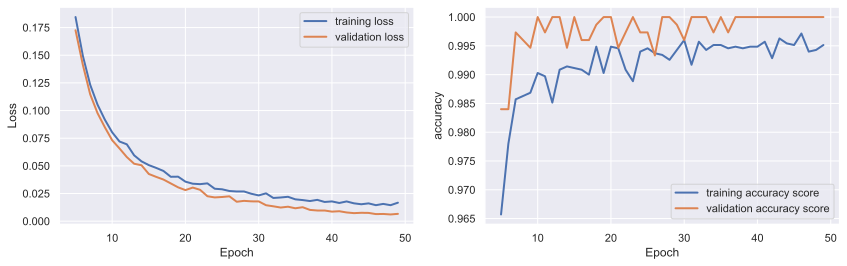

In [6]:
logs = pd.DataFrame(history.history)

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(logs.loc[5:,"loss"], lw=2, label='training loss')
plt.plot(logs.loc[5:,"val_loss"], lw=2, label='validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(logs.loc[5:,"accuracy"], lw=2, label='training accuracy score')
plt.plot(logs.loc[5:,"val_accuracy"], lw=2, label='validation accuracy score')
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.legend(loc='lower right')
plt.show()

### Training an XGBoost Classifier

In [8]:
xgb = XGBClassifier(learning_rate=0.01, max_depth=5, n_estimators=200, 
                    min_child_weight = 10, subsample = 0.8)

xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=True)
preds = xgb.predict(X_test)

acc_xgb = accuracy_score(y_test, preds)


print("Accuracy: %3.2f" % (acc_xgb))


[0]	validation_0-logloss:0.68327	validation_1-logloss:0.68328
[1]	validation_0-logloss:0.67357	validation_1-logloss:0.67361
[2]	validation_0-logloss:0.66406	validation_1-logloss:0.66413
[3]	validation_0-logloss:0.65475	validation_1-logloss:0.65482
[4]	validation_0-logloss:0.64560	validation_1-logloss:0.64570
[5]	validation_0-logloss:0.63663	validation_1-logloss:0.63673
[6]	validation_0-logloss:0.62783	validation_1-logloss:0.62794
[7]	validation_0-logloss:0.61920	validation_1-logloss:0.61930
[8]	validation_0-logloss:0.61072	validation_1-logloss:0.61084
[9]	validation_0-logloss:0.60240	validation_1-logloss:0.60251
[10]	validation_0-logloss:0.59423	validation_1-logloss:0.59433
[11]	validation_0-logloss:0.58620	validation_1-logloss:0.58630
[12]	validation_0-logloss:0.57831	validation_1-logloss:0.57842
[13]	validation_0-logloss:0.57058	validation_1-logloss:0.57067
[14]	validation_0-logloss:0.56297	validation_1-logloss:0.56306
[15]	validation_0-logloss:0.55549	validation_1-logloss:0.55560
[1

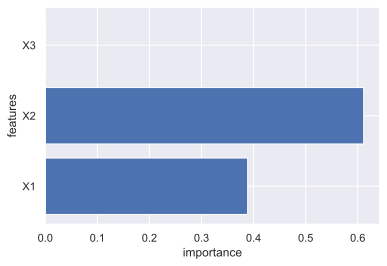

In [9]:
def plot_feature_importances(model):
      n_features = X.shape[1]
      plt.barh(range(n_features),model.feature_importances_,align="center")
      plt.yticks(np.arange(n_features),X)
      plt.xlabel("importance")
      plt.ylabel("features")
      plt.show

plot_feature_importances(xgb)
   

### Generating Explanations for XGBoost

In [10]:
from  lime.lime_tabular import LimeTabularExplainer
explainer = LimeTabularExplainer(X_train, feature_names=features, class_names=["Y:0", "Y:1"])
explainer

Prediction: 1


/usr/local/anaconda3/envs/python_base/lib/python3.10/site-packages/lime/lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


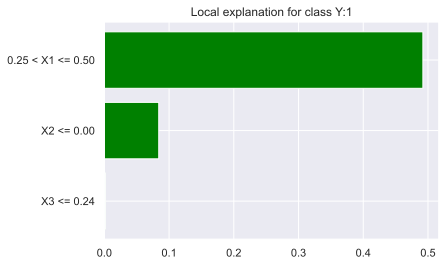

In [11]:
indx = 5

res = xgb.predict_proba([X_test[indx]])
print( "Prediction: " + str(np.argmax(res[0])) )

exp = explainer.explain_instance(X_test[indx], xgb.predict_proba, num_features=3)
fig = exp.as_pyplot_figure()

### Generating Explanations for Neural Net


In [12]:
from  lime.lime_tabular import LimeTabularExplainer
explainer_nn = LimeTabularExplainer(X_train, feature_names=features, class_names=["Y:0", "Y:1"])
explainer_nn

In [13]:
predict_fn = lambda x:  1.0 if nn.predict(x) >= 0.5 else 0.0

157/157 [==============================] - 0s 608us/step


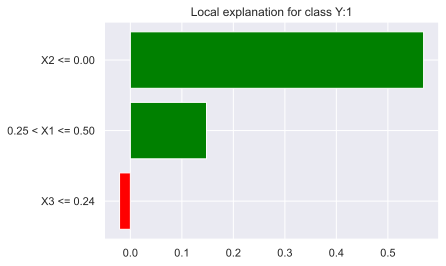

In [14]:
indx = 5

instance1 =  np.expand_dims(X_test[indx], axis=0) 
instance2 =  X_test[indx]

exp = explainer.explain_instance(X_test[indx], nn.predict, num_features=3)
fig = exp.as_pyplot_figure()

In [45]:
explainer_bn = LimeTabularExplainer(X_train, feature_names=features, class_names=["Y:0", "Y:1"])
explainer_bn

In [46]:
indx = 5

instance1 =  np.expand_dims(X_test[indx], axis=0) 
instance2 =  X_test[indx]

exp = explainer_bn.explain_instance(X_test[indx], clf.predict_proba, num_features=3)
fig = exp.as_pyplot_figure()

OutOfBounds: [pyAgrum] Out of bound error: label '0.9999999999883493' is unknown in X2:Labelized({0.0|1.0})